In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm

In [3]:
import sys
sys.path.insert(0, '/home/niell_lab/Documents/github/FreelyMovingEphys/')

In [4]:
from utils.aux_funcs import nanmedfilt

In [2]:
nc_path = '/home/niell_lab/Desktop/topdown_testing/110521/J569LT/fm1/110521_J569LT_control_Rig2_TOP1.nc'

In [3]:
top_data = xr.open_dataset(nc_path)

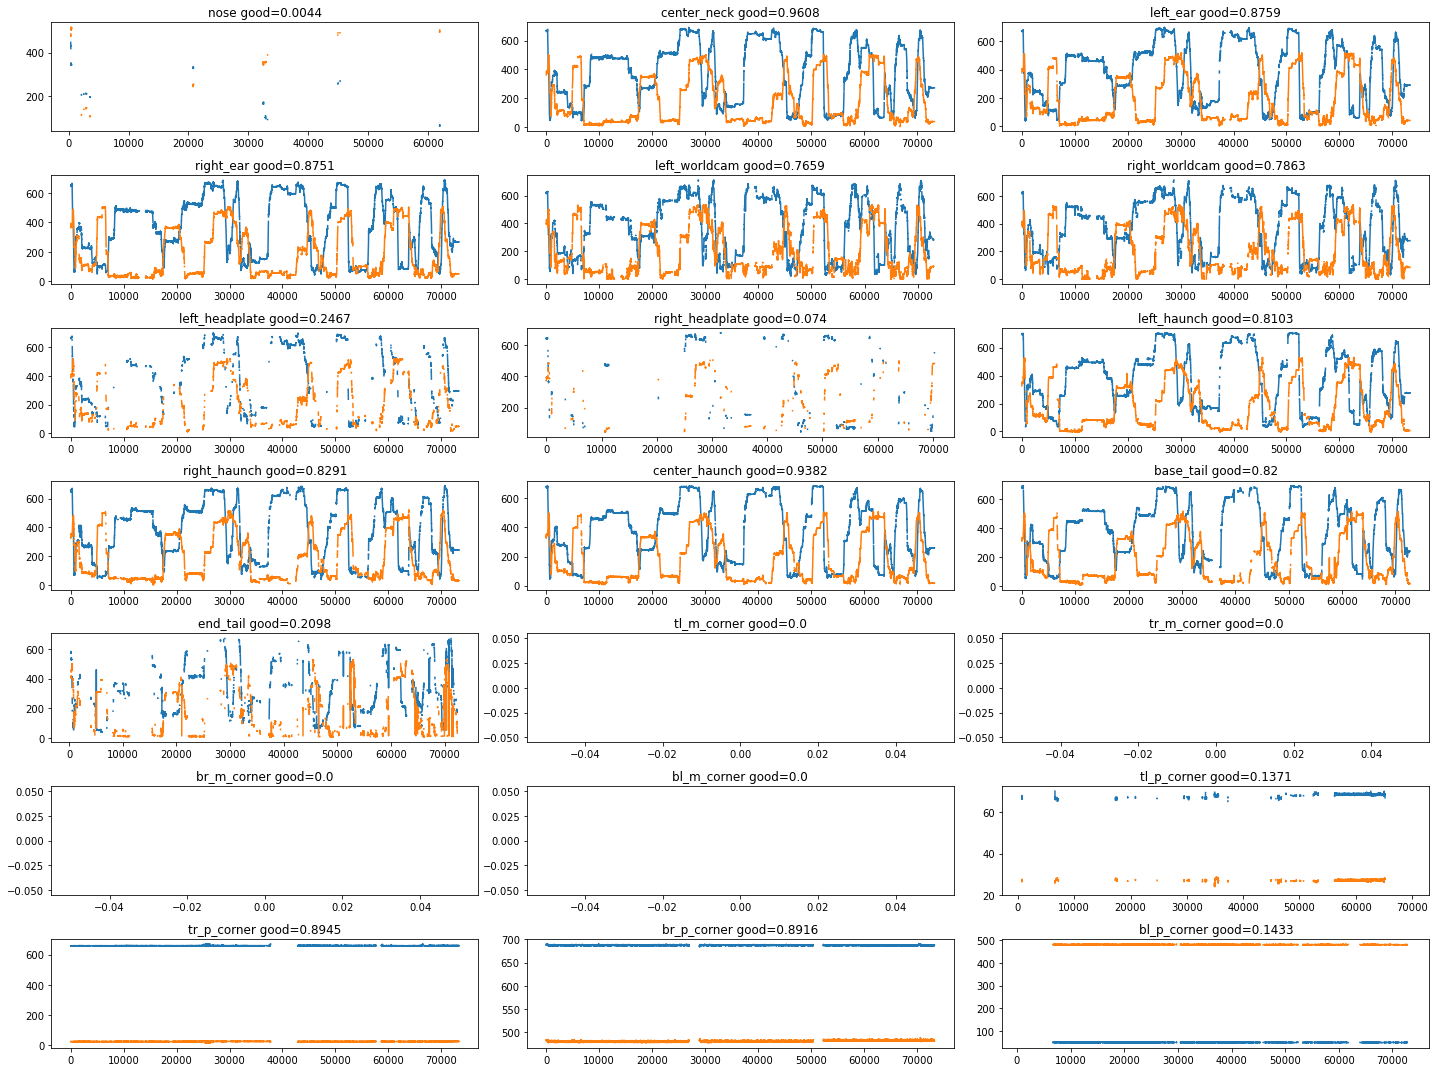

In [4]:
pt_names = list(top_data.TOP1_pts['point_loc'].values)
x_cols = [i for i in pt_names if '_x' in i]
y_cols = [i for i in pt_names if '_y' in i]
plt.subplots(int(np.ceil(len(pt_names)/9)),3,figsize=(20,15))
for i in range(len(x_cols)):
    x = top_data.TOP1_pts.sel(point_loc=x_cols[i])
    y = top_data.TOP1_pts.sel(point_loc=y_cols[i])
    plt.subplot(int(np.ceil(len(pt_names)/9)),3,i+1)
    plt.plot(x)
    plt.plot(y)
    frac_good = np.sum(~np.isnan(x) * ~np.isnan(y)) / len(x)
    plt.title(pt_names[::3][i][:-2] + ' good='+str(np.round(frac_good.values,4)))
plt.tight_layout()

In [5]:
pts = top_data.TOP1_pts

In [6]:
vid = top_data.TOP1_video.values

In [7]:
nose_x = pts.sel(point_loc='nose_x').values
nose_y = pts.sel(point_loc='nose_y').values
lwc_x = pts.sel(point_loc='left_worldcam_x').values
lwc_y = pts.sel(point_loc='left_worldcam_y').values
rwc_x = pts.sel(point_loc='right_worldcam_x').values
rwc_y = pts.sel(point_loc='right_worldcam_y').values
neck_x = pts.sel(point_loc='center_neck_x').values
neck_y = pts.sel(point_loc='center_neck_y').values
nose_mask = (~np.isnan(nose_x) * ~np.isnan(nose_y))

In [8]:
mask = np.where(~np.isnan(nose_x) * ~np.isnan(nose_y) * ~np.isnan(rwc_x) * ~np.isnan(rwc_y) * ~np.isnan(lwc_x) * ~np.isnan(lwc_y))

In [9]:
# plastic or metal corners?
ctypes = ['m','p']
frac_good = np.zeros(2)
for ctypenum in range(2):
    ctype = ctypes[ctypenum]
    fg = 0
    for cpos in ['tl','tr','br','bl']:
        cname = cpos+'_'+ctype+'_corner_'
        x = pts.sel(point_loc=cname+'x')
        y = pts.sel(point_loc=cname+'y')
        fg += np.sum(~np.isnan(x) * ~np.isnan(y)) / len(x)
    frac_good[ctypenum] = fg
metal_corners = np.argmax(frac_good)==0

In [10]:
# define cm using top or bottom corners?
frac_good = np.zeros(2)
m_or_p = ('m' if metal_corners else 'p')
for c, poslet in enumerate(['t','b']):
    fg = 0
    for lrpos in ['l','r']:
        cname = poslet+lrpos+'_'+m_or_p+'_corner_'
        x = pts.sel(point_loc=cname+'x')
        y = pts.sel(point_loc=cname+'y')
        fg += np.sum(~np.isnan(x) * ~np.isnan(y)) / len(x)
    frac_good[c] = fg
use_top_for_dist = np.argmax(frac_good)==0

In [21]:
# convert from pxls to cm

# distance between walls (left to right) is 40cm
# posts extend 0.5cm into arena on both sides
# distance between corners is 39cm

tb = ('t' if use_top_for_dist else 'b')
mp = ('m' if metal_corners else 'p')
left = tb+'l_'+mp+'_corner_x'
right = tb+'r_'+mp+'_corner_x'

dist_pxls = np.nanmedian(pts.sel(point_loc=right)) - np.nanmedian(pts.sel(point_loc=left))
dist_cm = 39
pxls2cm = dist_pxls / dist_cm

# pt_names = list(top_data.TOP1_pts['point_loc'].values)
# x_cols = [i for i in pt_names if '_x' in i]
# y_cols = [i for i in pt_names if '_y' in i]

# for i in range(len(x_cols)):
#     pts.sel(point_loc=x_cols[i]+'_cm')
    
#     pts[x_cols[i]+'_cm'] = self.data.loc[:,x_cols[i]] / self.pxls2cm
#     self.data[y_cols[i]+'_cm'] = self.data.loc[:,y_cols[i]] / self.pxls2cm

In [22]:
pxls2cm

16.359573119725937

In [26]:
topT = top_data.timestamps.copy()

In [31]:
from scipy.signal import medfilt

In [45]:
from utils.aux_funcs import smooth_convolve

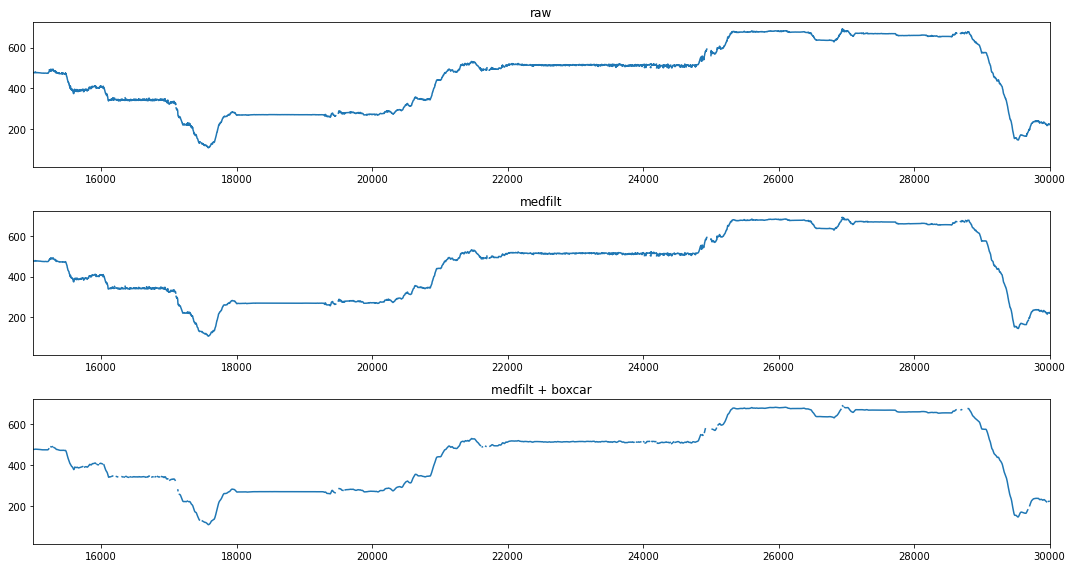

In [47]:
neck_raw = pts.sel(point_loc='center_neck_x').values
neck_medfilt = medfilt(neck_raw, kernel_size=5)
neck_boxcar = smooth_convolve(neck_medfilt, box_pts=20)

plt.subplots(3,1,figsize=(15,8))

plt.subplot(311)
plt.plot(neck_raw)
plt.title('raw')
plt.xlim([15000,30000])

plt.subplot(312)
plt.plot(neck_medfilt)
plt.title('medfilt')
plt.xlim([15000,30000])

plt.subplot(313)
plt.plot(neck_boxcar)
plt.title('medfilt + boxcar')
plt.xlim([15000,30000])
plt.tight_layout()

In [56]:
smooth_x = smooth_convolve(medfilt(pts.sel(point_loc='center_neck_x').values, kernel_size=5), box_pts=20)
smooth_y = smooth_convolve(medfilt(pts.sel(point_loc='center_neck_y').values, kernel_size=5), box_pts=20)

In [69]:
top_speed = np.sqrt(np.diff((smooth_x*60) / pxls2cm)**2 + np.diff((smooth_y*60) / pxls2cm)**2)

In [72]:
top_speed[top_speed>25] = np.nan

Text(0, 0.5, 'cm/sec')

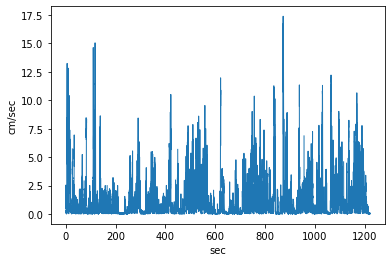

In [265]:
plt.plot(topT[:-1]-topT[0], top_speed, linewidth=1)
plt.xlabel('sec')
plt.ylabel('cm/sec')

Text(0, 0.5, 'fraction of time')

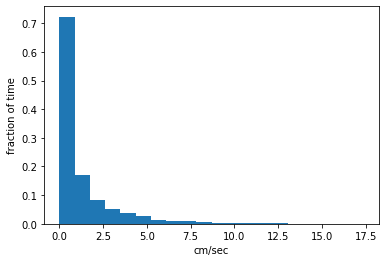

In [267]:
plt.hist(top_speed, bins=20, density=True)
plt.xlabel('cm/sec')
plt.ylabel('fraction of time')

In [101]:
lear_x = medfilt(pts.sel(point_loc='left_ear_x').values, kernel_size=5)
lear_y = medfilt(pts.sel(point_loc='left_ear_y').values, kernel_size=5)
rear_x = medfilt(pts.sel(point_loc='right_ear_x').values, kernel_size=5)
rear_y = medfilt(pts.sel(point_loc='right_ear_y').values, kernel_size=5)

In [164]:
yaw_rad = np.arctan2((lear_y - rear_y), (lear_x - rear_x)) + np.deg2rad(90)
yaw_deg = np.rad2deg(yaw_rad % (2*np.pi))

/tmp/ipykernel_3011968/2108648712.py:2: RuntimeWarning: invalid value encountered in remainder
  yaw_deg = np.rad2deg(yaw_rad % (2*np.pi))


Text(0.5, 0, 'sec')

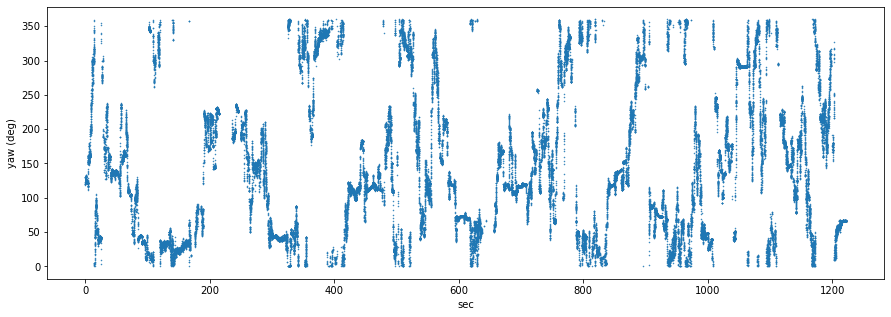

In [273]:
plt.figure(figsize=(15,5))
plt.plot(topT-topT[0], yaw_deg, '.', markersize=1)
plt.ylabel('yaw (deg)')
plt.xlabel('sec')

In [166]:
neck_x = pts.sel(point_loc='center_neck_x').values
neck_y = pts.sel(point_loc='center_neck_y').values

In [275]:
back_x = pts.sel(point_loc='center_haunch_x').values
back_y = pts.sel(point_loc='center_haunch_y').values

In [283]:
body_yaw_rad = np.arctan2((neck_y - back_y), (neck_x - back_x))
body_yaw_deg = np.rad2deg(body_yaw_rad % (2*np.pi))

/tmp/ipykernel_3011968/1761451720.py:2: RuntimeWarning: invalid value encountered in remainder
  body_yaw_deg = np.rad2deg(body_yaw_rad % (2*np.pi))


Text(0.5, 0, 'sec')

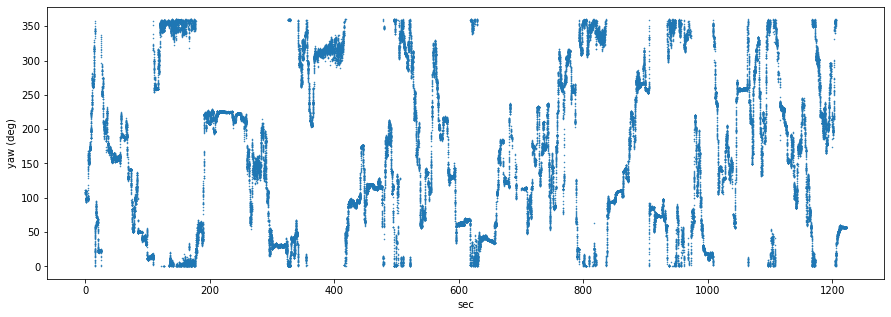

In [284]:
plt.figure(figsize=(15,5))
plt.plot(topT-topT[0], body_yaw_deg, '.', markersize=1)
plt.ylabel('yaw (deg)')
plt.xlabel('sec')

In [293]:
body_head_diff = yaw_deg - body_yaw_deg
body_head_diff[body_head_diff<-120] = np.nan
body_head_diff[body_head_diff>120] = np.nan

Text(0.5, 0, 'sec')

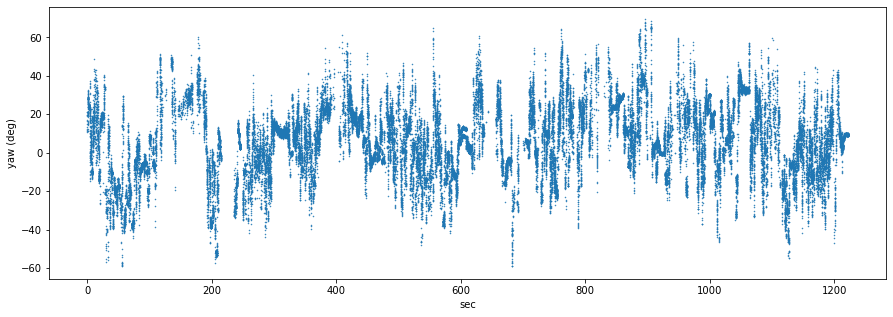

In [294]:
plt.figure(figsize=(15,5))
plt.plot(topT-topT[0], body_head_diff, '.', markersize=1)
plt.ylabel('yaw (deg)')
plt.xlabel('sec')

(array([  23.,  122.,   42.,   83.,  321.,  555.,  740.,  880., 1228.,
        1941., 2322., 3037., 4077., 4150., 4289., 4706., 5236., 3592.,
        3287., 3078., 2166., 2017.,  958.,  553.,  279.,  210.,  100.,
          65.,   36.,   13.]),
 array([-59.19980232, -54.91264659, -50.62549086, -46.33833514,
        -42.05117941, -37.76402368, -33.47686796, -29.18971223,
        -24.9025565 , -20.61540077, -16.32824505, -12.04108932,
         -7.75393359,  -3.46677787,   0.82037786,   5.10753359,
          9.39468931,  13.68184504,  17.96900077,  22.2561565 ,
         26.54331222,  30.83046795,  35.11762368,  39.4047794 ,
         43.69193513,  47.97909086,  52.26624659,  56.55340231,
         60.84055804,  65.12771377,  69.41486949]),
 <BarContainer object of 30 artists>)

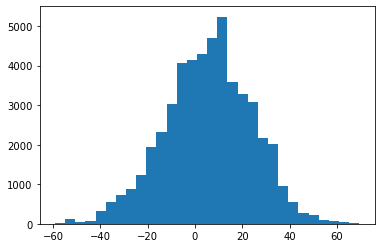

In [296]:
plt.hist(body_head_diff, bins=30)

In [211]:
x_disp = np.diff((smooth_x*60) / pxls2cm)
y_disp = np.diff((smooth_y*60) / pxls2cm)

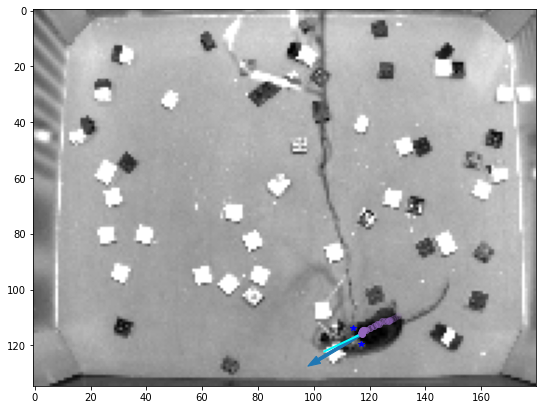

In [217]:
f = 350
plt.figure(figsize=(9,9))
plt.imshow(vid[f,:,:].astype(np.uint8), cmap='gray')
plt.plot(lear_x[f]*0.25, lear_y[f]*0.25, 'b*')
plt.plot(rear_x[f]*0.25, rear_y[f]*0.25, 'b*')
svec = top_speed[f]*2
# plt.plot([lear_x[f]*0.25, (lear_x[f]*0.25)+10*np.cos(lang[f])], [lear_y[f]*0.25, (lear_y[f]*0.25)+10*np.sin(lang[f])], '-', linewidth=4, color='g')
# plt.plot([rear_x[f]*0.25, (rear_x[f]*0.25)+10*np.cos(rang[f])], [rear_y[f]*0.25, (rear_y[f]*0.25)+10*np.sin(rang[f])], '-', linewidth=4, color='b')
plt.plot([neck_x[f]*0.25, (neck_x[f]*0.25)+15*np.cos(yaw_rad[f])], [neck_y[f]*0.25, (neck_y[f]*0.25)+15*np.sin(yaw_rad[f])], '-', linewidth=2, color='cyan')
maxprev = 25
for p in range(maxprev):
    prevf = f - p
    plt.plot(neck_x[prevf]*0.25, neck_y[prevf]*0.25, 'o', color='tab:purple', alpha=(maxprev-p)/maxprev)
plt.arrow(neck_x[f]*0.25, neck_y[f]*0.25, x_disp[f]*3, y_disp[f]*3, color='tab:blue', width=1)

In [214]:
x_disp[f]

-5.231558240790491

In [209]:
x_disp = np.diff((smooth_x*60) / pxls2cm)
x_disp

array([122.57126811, 122.58580724, 122.59122444, ..., -50.10069273,
       -50.09924889, -50.09197932])

In [199]:
maxprev = 20

0.0

In [173]:
import matplotlib as mpl
mpl.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
from matplotlib.animation import FFMpegWriter
import cv2
from tqdm import tqdm

In [325]:
vidpath = '/home/niell_lab/Desktop/topdown_demo.mp4'

In [326]:
np.shape(frame_as_array)

(288, 432, 3)

In [413]:
start = 31250
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out_vid = cv2.VideoWriter(vidpath, fourcc, 60.0, (432, 288))
maxprev = 25
for f in tqdm(range(start,start+3600)):
    fig = plt.figure()
    plt.imshow(vid[f,:,:].astype(np.uint8), cmap='gray')
    plt.plot(lear_x[f]*0.25, lear_y[f]*0.25, 'b*')
    plt.plot(rear_x[f]*0.25, rear_y[f]*0.25, 'b*')
#     svec = top_speed[f]*2
    # plt.plot([lear_x[f]*0.25, (lear_x[f]*0.25)+10*np.cos(lang[f])], [lear_y[f]*0.25, (lear_y[f]*0.25)+10*np.sin(lang[f])], '-', linewidth=4, color='g')
    # plt.plot([rear_x[f]*0.25, (rear_x[f]*0.25)+10*np.cos(rang[f])], [rear_y[f]*0.25, (rear_y[f]*0.25)+10*np.sin(rang[f])], '-', linewidth=4, color='b')
    plt.plot([neck_x[f]*0.25, (neck_x[f]*0.25)+15*np.cos(yaw_rad[f])], [neck_y[f]*0.25, (neck_y[f]*0.25)+15*np.sin(yaw_rad[f])], '-', linewidth=2, color='cyan')
    plt.plot([back_x[f]*0.25, (back_x[f]*0.25)-15*np.cos(body_yaw_rad[f])], [back_y[f]*0.25, (back_y[f]*0.25)-15*np.sin(body_yaw_rad[f])], '-', linewidth=2, color='pink')
    for p in range(maxprev):
        prevf = f - p
        plt.plot(neck_x[prevf]*0.25, neck_y[prevf]*0.25, 'o', color='tab:purple', alpha=(maxprev-p)/maxprev)
    if running_forward[f]:
        plt.arrow(neck_x[f]*0.25, neck_y[f]*0.25, x_disp[f]*3, y_disp[f]*3, color='tab:green', width=1)
    elif not running_forward[f]:
        plt.arrow(neck_x[f]*0.25, neck_y[f]*0.25, x_disp[f]*3, y_disp[f]*3, color='tab:red', width=1)
    fig.canvas.draw()
    frame_as_array = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    frame_as_array = frame_as_array.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close()
    img = cv2.cvtColor(frame_as_array, cv2.COLOR_RGB2BGR)
    out_vid.write(img.astype('uint8'))
out_vid.release()

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
  0%|                                                                                               | 0/3600 [00:00<?, ?it/s]/tmp/ipykernel_3011968/163043338.py:23: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  frame_as_array = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
100%|████████████████████████████████████████████████████████████████████████████████████| 3600/3600 [04:09<00:00, 14.46it/s]


In [178]:
xbounds = np.array([np.nanmedian(pts.sel(point_loc='tl_p_corner_x').values),
                    np.nanmedian(pts.sel(point_loc='tr_p_corner_x').values),
                    np.nanmedian(pts.sel(point_loc='br_p_corner_x').values),
                    np.nanmedian(pts.sel(point_loc='bl_p_corner_x').values),
                    np.nanmedian(pts.sel(point_loc='tl_p_corner_x').values)])
ybounds = np.array([np.nanmedian(pts.sel(point_loc='tl_p_corner_y').values),
                    np.nanmedian(pts.sel(point_loc='tr_p_corner_y').values),
                    np.nanmedian(pts.sel(point_loc='br_p_corner_y').values),
                    np.nanmedian(pts.sel(point_loc='bl_p_corner_y').values),
                    np.nanmedian(pts.sel(point_loc='tl_p_corner_y').values)])

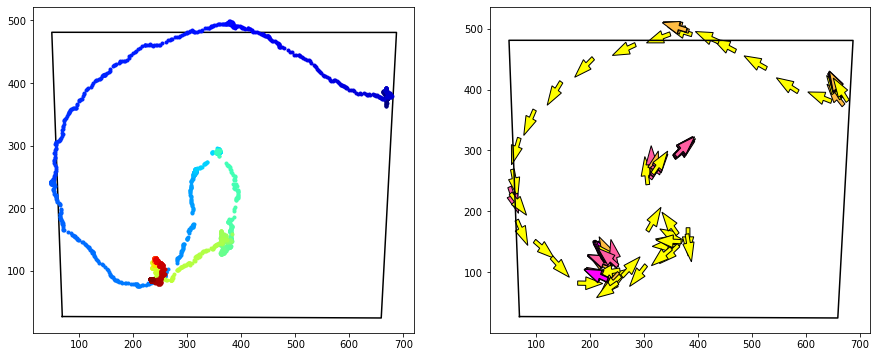

In [264]:
maxf = 3600
plt.subplots(1,2,figsize=(15,6))
plt.subplot(121)
plt.plot(xbounds, ybounds, 'k-')
cmap = plt.cm.jet(np.linspace(0,1,maxf))
for f in range(maxf):
    plt.plot(neck_x[f], neck_y[f], '.', color=cmap[f])

plt.subplot(122)
plt.plot(xbounds, ybounds, 'k-')
speed_bins = np.linspace(0,int(np.ceil(np.nanmax(top_speed))))
spdcolors = plt.cm.spring(speed_bins)
for f in np.arange(0,maxf+25,25):
    if ~np.isnan(top_speed[f]):
        usecolor = spdcolors[np.argmin(np.abs(top_speed[f] - speed_bins))]
    else:
        continue
    x0 = neck_x[f]
    y0 = neck_y[f]
    dX = 15*np.cos(yaw_rad[f])
    dY = 15*np.sin(yaw_rad[f])
    plt.arrow(x0, y0, dX, dY, facecolor=usecolor, width=7, edgecolor='k')


In [ ]:
# to be a forward run, must be above 2.5cm/sec and heading must be +/- 8deg of head angle

In [399]:
running_forward = (top_speed>2) * (np.abs(body_head_diff)<9)[:-1]

In [400]:
np.sum(running_forward)/60

61.46666666666667

In [401]:
start_inds = np.where(np.diff(running_forward.astype(int))==1)[0]
stop_inds = np.where(np.diff(running_forward.astype(int))==-1)[0]

In [402]:
start_stop_times = [(start_inds[i],stop_inds[i]) for i in range(len(start_inds))]
longest_run = np.argmax([t[1]-t[0] for t in start_stop_times])

In [403]:
longest_run

200

In [405]:
best = start_stop_times[200]

In [406]:
best[1]-best[0]

55

(array([393., 107.,  49.,  17.,   4.,   9.,   3.,   5.,   0.,   1.]),
 array([ 1. ,  6.4, 11.8, 17.2, 22.6, 28. , 33.4, 38.8, 44.2, 49.6, 55. ]),
 <BarContainer object of 10 artists>)

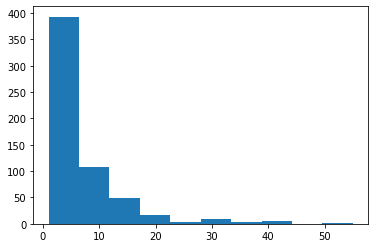

In [408]:
plt.hist([t[1]-t[0] for t in start_stop_times])

In [410]:
print(best)

(31375, 31430)


(31250.0, 32250.0)

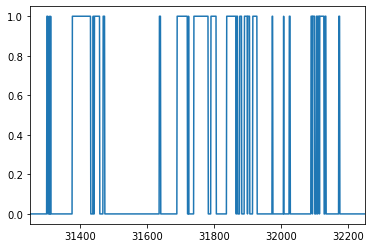

In [412]:
start = 31250
plt.plot(running_forward)
plt.xlim([start,start+1000])

In [ ]:
plt.plot()

In [229]:
speed_bins = np.linspace(0,int(np.ceil(np.nanmax(top_speed))))

17

In [234]:
len(speed_bins)

50

In [219]:
top_speed[f]

0.019442783030491854

In [152]:
np.rad2deg(lang[f])

68.89392590238053

In [153]:
np.rad2deg(rang[f])

67.8263013577862

In [154]:
np.rad2deg(yaw_rad[f])

1.0676245445943215

In [ ]:
f = 341
plt.figure(figsize=(9,9))
xrange = [np.nanmin([nose_x[f], lwc_x[f], rwc_x[f], neck_x[f]])-50, np.nanmax([nose_x[f], lwc_x[f], rwc_x[f], neck_x[f]])+50]
yrange = [np.nanmax([nose_y[f], lwc_y[f], rwc_y[f], neck_y[f]])+60, np.nanmin([nose_y[f], lwc_y[f], rwc_y[f], neck_y[f]])-60]
xrange = [int(x*0.25) for x in xrange]
yrange = [int(y*0.25) for y in yrange]
plt.imshow(vid[f,:,:].astype(np.uint8), cmap='gray')
plt.autoscale(False)
plt.plot(nose_x[f]*0.25, nose_y[f]*0.25, 'ro', label='nose')
plt.plot(lwc_x[f]*0.25, lwc_y[f]*0.25, 'go', label='left worldcam')
plt.plot(rwc_x[f]*0.25, rwc_y[f]*0.25, 'bo', label='right worldcam')
plt.plot(neck_x[f]*0.25, neck_y[f]*0.25, 'yo', label='neck')
plt.xlim(xrange); plt.ylim(yrange)
plt.legend()
plt.plot([neck_x[f]*0.25, nose_x[f]*0.25], [neck_y[f]*0.25, nose_y[f]*0.25], '--', color='tab:purple')
plt.plot([neck_x[f]*0.25, rwc_x[f]*0.25], [neck_y[f]*0.25, rwc_y[f]*0.25], '--', color='tab:purple')

In [ ]:
top_heading

In [ ]:
(nose_x[f] - neck_x[f])**2 + nose_